## Нейросетевая классификация текстов

Ноутбук посвящен задаче классификации текстов c помощью RNN (vanilla RNN, GRU, LSTM).

Датасет - [ag_news](https://paperswithcode.com/dataset/ag-news). Классифицирует новости на 4 темы: "World", "Sports", "Business", "Sci/Tech".

In [ ]:
# Модуль datasets, чтобы было проще было работать с данными
!pip install datasets

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

import pickle

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
# Загрузка датасета
dataset = datasets.load_dataset('ag_news')

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Dataset ag_news downloaded and prepared to /root/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

# добавляем слова, встречающиеся больше 25 раз в корпусе
for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

# перевод из слов в индексы и наоборот
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 11842


In [ ]:
# храним здесь датасеты и передаем в torch.dataloader - методы конструтор,getitem, len

class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
      # удаляем пунктуацию, приводим строку в нижний регистр
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        # создаем токенизированную последовательность
        tokenized_sentence = [self.bos_id] # служебный токен в начале строк
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text) # достаем для каждого слова из предложения слово из словаря # если слова нет- возвращаем рабочий токен
            ]
        tokenized_sentence += [self.eos_id] ## служебный токен в конце строки

        train_sample = {
           # уже токенизованный текст
            "text": tokenized_sentence,
           # метка (лейбл)
            "label": self.data[idx]['label'] ##### ??????7
        }
            # print ('label', label)
        return train_sample

    def __len__(self) -> int:
        return len(self.data)


# сбор последовательностей разных длин в батч одной длины
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])
    # Long tensor -содержит целочисленные индексы токенов (слов)
    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }
    return new_batch

In [ ]:
train_dataset = WordDataset(dataset['train'])

# выбираем 5000 примеров
np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Постановка задачи
Задача - получить максимальное возможное accuracy на `eval_dataloader`.

In [ ]:
def evaluate(model) -> float:
    """
    Calculate accuracy on validation dataloader.
    """
    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

# бейзлайн RNN

In [ ]:
def model_train(num_epoch,
                model_type,
               model_name_path,
               model_name_losses_type,
               model_name_acc_type
               ):
    eval_steps = len(train_dataloader) // 2

    losses_type = {}
    acc_type = {}

    for aggregation_type in ['max', 'mean']:
        print(f"Starting training for {aggregation_type}")
        losses = []
        acc = []

        if model_type  == "RNN":
            print ('сейчас RNN')
            model_instance  = RNN(hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
        elif model_type  == "GRU":
            print ('сейчас GRU')
            model_instance  = GRU(hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
        elif model_type  == "LSTM":
            print ('сейчас LSTM')
            model_instance  = LSTM(hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
#         else:
#             raise ValueError("Invalid model type")

        criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
        optimizer = torch.optim.Adam(model_instance .parameters())

        for epoch in range(num_epoch):
            epoch_losses = []
            model_instance .train()
            for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
                optimizer.zero_grad()
                logits = model_instance (batch['input_ids'])
                loss = criterion(logits, batch['label'])
                loss.backward()
                optimizer.step()

                epoch_losses.append(loss.item())
                if i % eval_steps == 0:
                    model_instance .eval()
                    acc.append(evaluate(model_instance))
                    model_instance .train()

            losses.append(sum(epoch_losses) / len(epoch_losses))

        losses_type[aggregation_type] = losses
        acc_type[aggregation_type] = acc

    # Сохранение модели
    torch.save(model_instance.state_dict(), f'{model_name_path}.pth')

    # Сохранение списков losses_type и acc_type
    with open(f'{model_name_losses_type}.pkl', 'wb') as f:
        pickle.dump(losses_type, f)
    with open(f'{model_name_acc_type}.pkl', 'wb') as f:
        pickle.dump(acc_type, f)

    for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
        plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

    plt.title('Losses')
    plt.xlabel("epoch")
    plt.legend()
    plt.show()

    for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
        plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
        print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

    plt.title('Accuracy')
    plt.xlabel("epoch")
    plt.legend()
    plt.show()

In [ ]:
class RNN(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)

        # вход скрытая размерность=выходной
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True) # входная и выходная размерности равны
        self.linear = nn.Linear(hidden_dim, hidden_dim)

        # из скрытой размерности проектирует в классы
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # на выходе имеются 3 размерности - [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

Starting training for max
сейчас RNN


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean
сейчас RNN


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

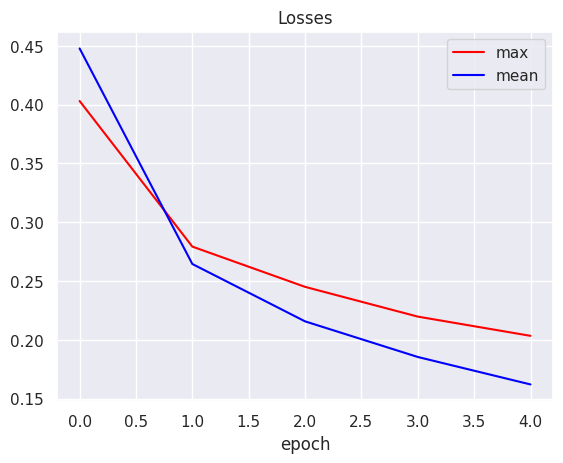

Лучшая accuracy для подхода max: 90.62
Лучшая accuracy для подхода mean: 90.44


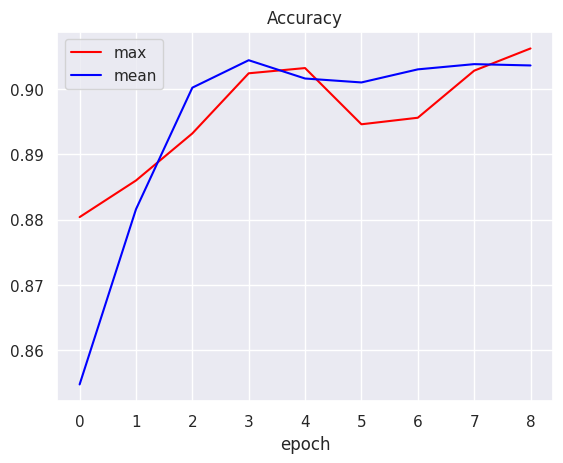

In [ ]:
num_epoch = 5

RNN_baseline_model=model_train(num_epoch,'RNN',
                              'RNN_baseline_model',
                              'RNN_baseline_losses_type',
                              'RNN_baseline_acc_type')

## Эксперименты по улучшению модели.
## GRU (without hyperparameters fit)

In [ ]:
class GRU(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)

        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True) # входная и выходная размерности равны
        self.linear = nn.Linear(hidden_dim, hidden_dim)

        # из скрытой размерности проектирует в классы
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # на выходе имеются 3 размерности - [batch_size, seq_len, hidden_dim]
        output, _ = self.gru(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

Starting training for max
сейчас GRU


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean
сейчас GRU


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

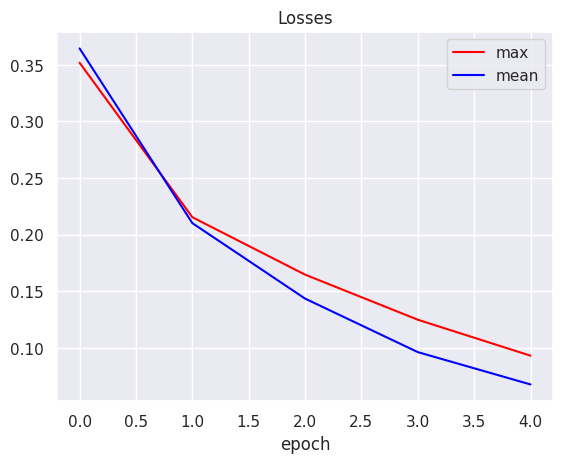

Лучшая accuracy для подхода max: 91.28
Лучшая accuracy для подхода mean: 91.00


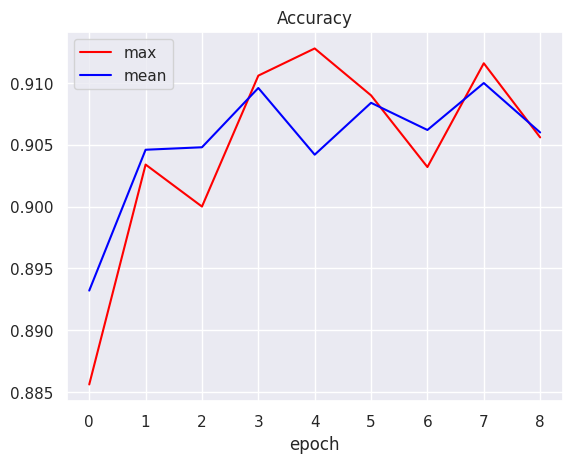

In [ ]:
num_epoch = 5

GRU_model=model_train(num_epoch,'GRU',
                              'GRU_model',
                              'GRU_losses_type',
                              'GRU_acc_type')

## LSTM (without hyperparameters fitting)

In [ ]:
class LSTM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)

        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True) # входная и выходная размерности равны
        self.linear = nn.Linear(hidden_dim, hidden_dim)

        # из скрытой размерности проектирует в классы
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # на выходе имеются 3 размерности - [batch_size, seq_len, hidden_dim]
        output, _ = self.lstm(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

Starting training for max
сейчас LSTM


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean
сейчас LSTM


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

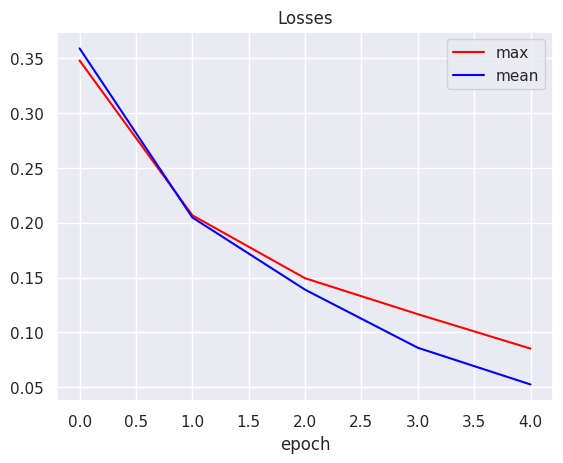

Лучшая accuracy для подхода max: 91.12
Лучшая accuracy для подхода mean: 91.50


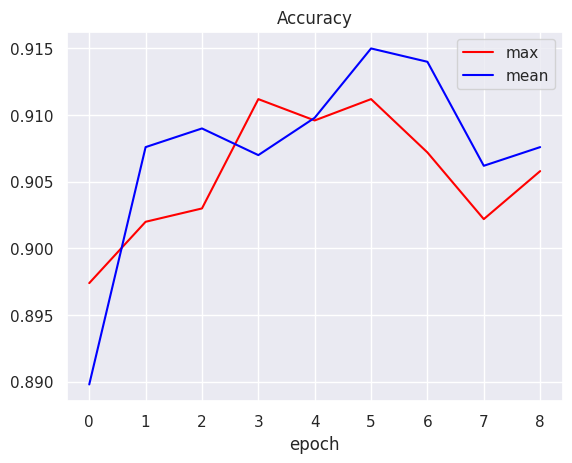

In [ ]:
num_epoch = 5

LSTM_model=model_train(num_epoch,'LSTM',
                              'LSTM_model',
                              'LSTM_losses_type',
                              'LSTM_acc_type')

## LSTM (2 num layers)

In [ ]:
class LSTM_model2(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)

        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers=2, batch_first=True) # входная и выходная размерности равны
        self.linear = nn.Linear(hidden_dim, hidden_dim)

        # из скрытой размерности проектирует в классы
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # на выходе имеются 3 размерности - [batch_size, seq_len, hidden_dim]
        output, _ = self.lstm(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

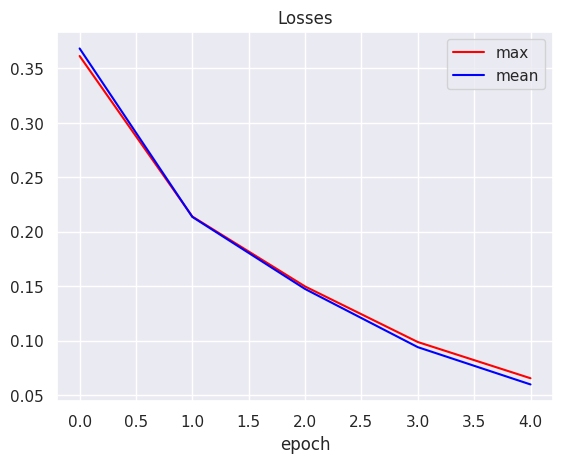

Лучшая accuracy для подхода max: 91.32
Лучшая accuracy для подхода mean: 91.80


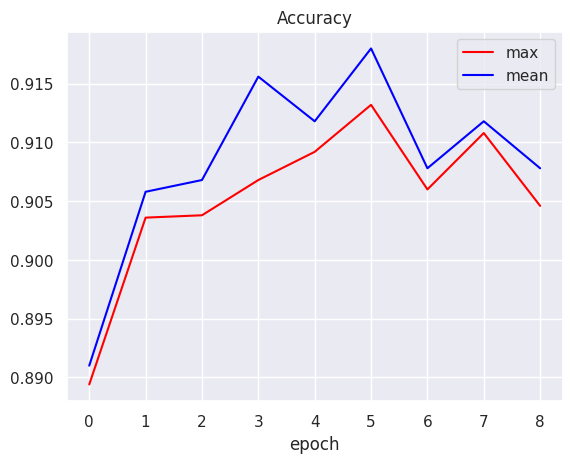

In [ ]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2

losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = LSTM_model2(hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model))
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

## LSTM (2 num layers, dropout=0.3)

In [ ]:
class LSTM_model3(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)

        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers=2, batch_first=True) # входная и выходная размерности равны
        self.linear = nn.Linear(hidden_dim, hidden_dim)

        # из скрытой размерности проектирует в классы
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.3)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # на выходе имеются 3 размерности - [batch_size, seq_len, hidden_dim]
        output, _ = self.lstm(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

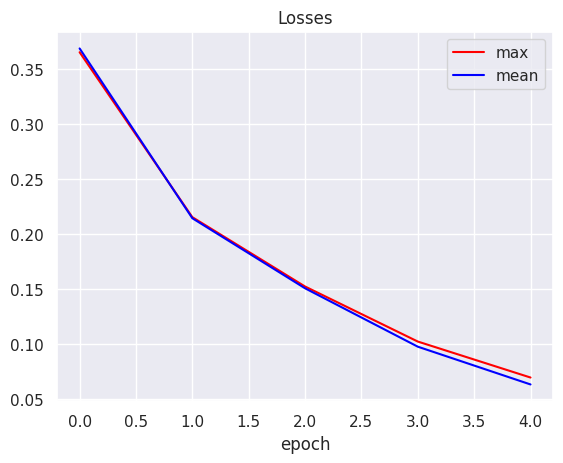

Лучшая accuracy для подхода max: 92.16
Лучшая accuracy для подхода mean: 91.44


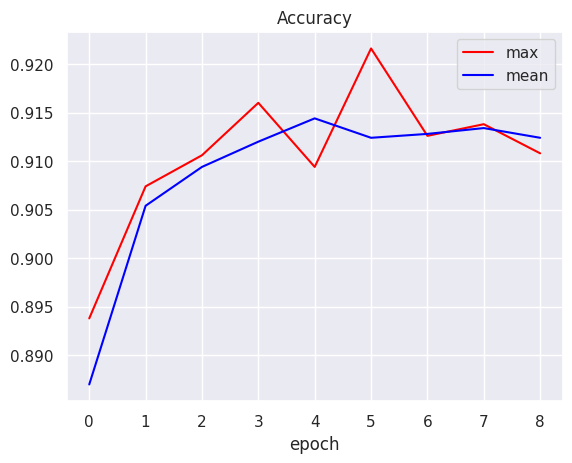

In [ ]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2

losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = LSTM_model3(hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model))
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

## LSTM(2 num layers,dropout=0.3)+counter_threshold

In [ ]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 18

# добавляем слова, встречающиеся больше 25 раз в корпусе
for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

# перевод из слов в индексы и наоборот

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

Размер словаря: 14243


In [ ]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
      # удаляем пунктуацию, приводим строку в нижний регистр
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        # создаем токенизированную последовательность
        tokenized_sentence = [self.bos_id] # служебный токен в начале строк
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text) # достаем для каждого слова из предложения слово из словаря # если слова нет- возвращаем рабочий токен
            ]
        tokenized_sentence += [self.eos_id] ## служебный токен в конце строки

        train_sample = {
           # уже токенизованный текст
            "text": tokenized_sentence,
           # метка (лейбл)
            "label": self.data[idx]['label'] ##### ??????7
        }
            # print ('label', label)
        return train_sample

    def __len__(self) -> int:
        return len(self.data)


# сбор последовательностей разных длин в батч одной длины

def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])
    # Long tensor -содержит целочисленные индексы токенов (слов)
    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }
    return new_batch

In [ ]:
rain_dataset = WordDataset(dataset['train'])

# выбираем 5000 примеров

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [ ]:
class LSTM_model4(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)

        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers=2, batch_first=True) # входная и выходная размерности равны
        self.linear = nn.Linear(hidden_dim, hidden_dim)

        # из скрытой размерности проектирует в классы
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.3)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # на выходе имеются 3 размерности - [batch_size, seq_len, hidden_dim]
        output, _ = self.lstm(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

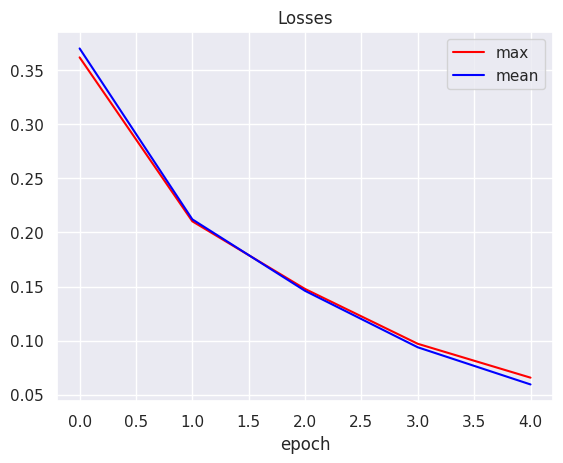

Лучшая accuracy для подхода max: 90.10
Лучшая accuracy для подхода mean: 90.38


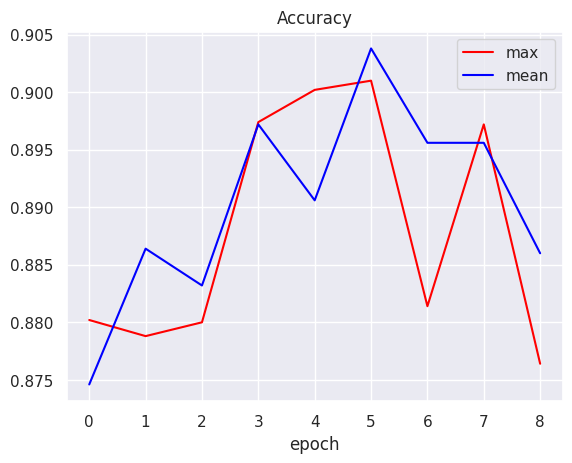

In [ ]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2

losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = LSTM_model4(hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model))
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

Выводы:
1. Базовая модель RNN обучена в разделе "Бейзлайн RNN". Получен бейзлайн скор:
- Лучшая accuracy : подхода max: 90.62
- Лучшая accuracy для подхода mean: 90.44

2. Проведены эксперименты по улучшению модели RNN:
- последовательно обучены модели GRU, LSTM без изменения параметров (разделы GRU и LSTM (without hyperparameters fit) ).

3. Т.к LSTM без изменения параметров дает наилучшее качество, она выбрана за основную,а для LSTM проведены следующие эксперименты: обучена LSTM
- с 2 рекуррентными слоями
- с 2 рекуррентными слоями и повышением dropout до 0.3
- с 2 рекуррентными слоями и повышением dropout до 0.3 и изменением размера словаря за счет снижения counter_threshold.

4. Последовательное обучение моделей в ноутбуке давало все лучшее качество, за исключением последней модели с 2 рекуррентными слоями и повышением dropout до 0.3 и изменением размера словаря за счет снижения counter_threshold.

5. Колебания качество моделей достаточно существены в зависимости от эпохи. Лучшее качество дала модель LSTM с 2 рекуррентными слоями, dropout=0.3, на подходе max после 5 эпох (Accuracy=92.16).

